In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Using Skicit-learn to split data into training and testing sets 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix

import rasterio
import geopandas as gpd

import pystac_client 
import planetary_computer as pc

from shapely.geometry import Polygon
from sklearn.metrics import RocCurveDisplay

#import iceplant_detection_functions as ipf

In [2]:
def iceplant_counts(df):
    return df.filter(items=['iceplant']).groupby(['iceplant']).size().reset_index(name='count')

def test_train_from_df(df,test_size=0.3):
    # Labels are the values we want to predict
    labels = np.array(df['iceplant'])
    #Convert to numpy array
    features = np.array(df.drop('iceplant', axis = 1))
    return train_test_split(features, labels, test_size = test_size, random_state = 42)

# --- check proportions of ice plant vs no ice plant in train/test sets
def test_train_proportions(train_labels, test_labels):
    print('TRAIN SET: Iceplant / no iceplant counts')
    unique, counts = np.unique(train_labels,return_counts=True)
    print(np.column_stack((unique,counts)), '\n')

    print('TEST SET: Iceplant / no iceplant counts')
    unique, counts = np.unique(test_labels,return_counts=True)
    print(np.column_stack((unique,counts)))
    print()
    return

# --- check shapes of train/test features/labels
def  train_test_shapes(train_features, train_labels, test_features, test_labels):
    print('Training Features Shape:', train_features.shape) 
    print('Training Labels Shape:', train_labels.shape) 
    print('Testing Features Shape:', test_features.shape) 
    print('Testing Labels Shape:', test_labels.shape)
    print()
    return

# **********************************************************************************************************

def print_accuracy_info(test_labels,predictions_class):
    N = test_labels.shape[0]
    results = confusion_matrix(test_labels,predictions_class, normalize = 'true')
    
    confmtx = confusion_matrix(test_labels,predictions_class)
    print('true negatives:', confmtx[0,0], 
          '    false positives:', confmtx[0,1])
    print('false negatives:', confmtx[1,0], 
          '    true positives:', confmtx[1,1])
    print()
    unique, counts = np.unique(test_labels,return_counts=True)

    print('true negative %:', np.round(confmtx[0,0]/counts[0]*100,2))
    print('true positive rate %:', np.round(confmtx[1,1]/counts[1]*100,2))
    print()
    print('accuracy %:', np.round( (confmtx[1,1] + confmtx[0,0])/test_labels.shape[0]*100,2))
    return

def plot_roc(rfc, test_features, test_labels):
    ax = plt.gca()
    rf_disp = RocCurveDisplay.from_estimator(rfc, test_features, test_labels, ax=ax)
    return

def print_abs_errors(predictions_class, test_labels):# Calculate the absolute errors
    errors_class = abs(predictions_class - test_labels)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors_class), 2))
    return

def print_rfc_evaluation(rfc, test_features, test_labels, predictions):
    print_abs_errors(predictions, test_labels)
    print()
    print_accuracy_info(test_labels,predictions)
    plot_roc(rfc, test_features, test_labels)
    print()
    return

def open_window_in_scene(itemid, reduce_box):
    # accesing Azure storage using pystac client
    URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
    catalog = pystac_client.Client.open(URL)

    itemid = itemid,
    search = catalog.search(
        collections=["naip"],
        ids = itemid
    )
    item = list(search.get_items())[0]
    # sign and open item
    href = pc.sign(item.assets["image"].href)
    ds = rasterio.open(href)


    reduce = gpd.GeoDataFrame({'geometry':[reduce_box]}, crs="EPSG:4326")
    reduce = reduce.to_crs(ds.crs)

    win = ds.window(*reduce.total_bounds)
    subset = rasterio.open(href).read([1,2,3,4], window=win)
    return subset


def predict_over_subset(itemid, reduce_box,rfc):
    subset = open_window_in_scene(itemid, reduce_box)
    # reshape image into a np.array where each row is a pixel and the columns are the bands
    pixels = subset.reshape([4,-1]).T
    predictions_class = rfc.predict(pixels)
    # turn back into original raster dimensions
    return predictions_class.reshape([subset.shape[1],-1])

# **********************************************************************************************************
# image is a (4,m,n) np array in which bands are r,g,b,nir

def select_ndvi_df(image,thresh=0.2):
    # reshape image into a np.array where each row is a pixel and the columns are the bands
    pixels = image.reshape([4,-1]).T
    df = pd.DataFrame(pixels, columns=['r','g','b','nir'])
    df['ndvi']=(df.nir.astype('int16') - df.r.astype('int16'))/(df.nir.astype('int16') + df.r.astype('int16'))
    vegetation = df[df.ndvi>thresh]
    vegetation.drop(labels=['ndvi'],axis=1, inplace=True)
    return vegetation

# ---------------------------------
def df_backto_image(image, df):
    reconstruct = np.zeros((image.shape[1],image.shape[2]))
    for n in df.index:
        if df.prediction[n]==1:
            i = int((n)/reconstruct.shape[1])
            j = (n) % reconstruct.shape[1]
            reconstruct[i][j] = 1
    return reconstruct

# ---------------------------------
def mask_ndvi_and_predict(itemid, reduce_box, rfc):
    image = open_window_in_scene(itemid, reduce_box)
    veg = select_ndvi_df(image)
    index = veg.index
    features = np.array(veg)
    predictions_class = rfc.predict(features)
    c = {'prediction':predictions_class}
    predictions_df = pd.DataFrame(c, index = index)
    
    return df_backto_image(image,predictions_df)

# **********************************************************************************************************
def plot_window_in_scene(itemid, reduce_box):
    # accesing Azure storage using pystac client
    URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
    catalog = pystac_client.Client.open(URL)

    itemid = itemid,
    search = catalog.search(
        collections=["naip"],
        ids = itemid
    )
    item = list(search.get_items())[0]
    # sign and open item
    href = pc.sign(item.assets["image"].href)
    ds = rasterio.open(href)
    
    reduce = gpd.GeoDataFrame({'geometry':[reduce_box]}, crs="EPSG:4326")
    reduce = reduce.to_crs(ds.crs)
    win = ds.window(*reduce.total_bounds)
    
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(np.moveaxis(rasterio.open(href).read([1,2,3], window=win),0,-1))
    plt.show()
    
    return

In [3]:
# image is a (4,m,n) np array in which bands are r,g,b,nir

def select_ndvi_df(image,thresh=0.2):
    # reshape image into a np.array where each row is a pixel and the columns are the bands
    pixels = image.reshape([4,-1]).T
    df = pd.DataFrame(pixels, columns=['r','g','b','nir'])
    df['ndvi']=(df.nir.astype('int16') - df.r.astype('int16'))/(df.nir.astype('int16') + df.r.astype('int16'))
    vegetation = df[df.ndvi>thresh]
    vegetation.drop(labels=['ndvi'],axis=1, inplace=True)
    return vegetation


# ---------------------------------

def select_ndvi_image(itemid, reduce_box):
    subset = open_window_in_scene(itemid, reduce_box)
    df = select_ndvi_df(subset)
    reconstruct = np.zeros((subset.shape[1],subset.shape[2]))
    for n in df.index:
        i = int((n)/reconstruct.shape[1])
        j = (n) % reconstruct.shape[1]
        reconstruct[i][j] = 1
    return reconstruct



In [4]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_non_iceplant_vegetation.csv')
noniceplant_features_df = pd.read_csv(fp)
#noniceplant_features_df.head(4)

In [5]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_BIG.csv')
features_df = pd.read_csv(fp)
#features_df.head(4)

In [6]:
# add non-vegetation points to BIG training set
features_df = pd.concat([features_df,
                         noniceplant_features_df.sample(frac=0.01)])
features_df.drop(['geometry','Unnamed: 0','x','y'],axis=1,inplace=True)
iceplant_counts(features_df)

,iceplant,count
0,0,5113
1,1,1609


In [7]:
features_df['ndvi']=(features_df.nifr.astype('int16') - features_df.r.astype('int16'))/(features_df.nifr.astype('int16') + features_df.r.astype('int16'))
#copy.drop_duplicates(subset = ['r','g','b','nifr'])
#features_df

In [8]:
features_df.drop(features_df[features_df['ndvi'] < 0.2].index)
vegetation = features_df[features_df.ndvi>0.2]
vegetation.drop('ndvi',axis=1,inplace=True)
#vegetation

/tmp/ipykernel_357/2785433110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop('ndvi',axis=1,inplace=True)


In [9]:
iceplant_counts(vegetation)

,iceplant,count
0,0,3089
1,1,1514


## Crete test and training sets

In [10]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = test_train_from_df(vegetation)

train_test_shapes(train_features, train_labels, test_features, test_labels)
test_train_proportions(train_labels, test_labels)

Training Features Shape: (3222, 4)
Training Labels Shape: (3222,)
Testing Features Shape: (1381, 4)
Testing Labels Shape: (1381,)

TRAIN SET: Iceplant / no iceplant counts
[[   0 2185]
 [   1 1037]] 

TEST SET: Iceplant / no iceplant counts
[[  0 904]
 [  1 477]]



In [11]:
rfc = RandomForestClassifier(n_estimators = 100, 
                           random_state = 42)
rfc.fit(train_features,train_labels)

RandomForestClassifier(random_state=42)

In [ ]:
predictions = rfc.predict(test_features)

In [ ]:
print_rfc_evaluation(rfc, test_features, test_labels, predictions)

## Applying RFC model to NAIP subsets

In [12]:
itemid='ca_m_3411934_sw_11_060_20180722_20190209'

# use one of these polygons to make a window and load only the portion of the raster we need

#  Campus Point + Campus + Goleta Beach
# reduce_box = Polygon([
#     [-119.8533036004,34.4025961754],
#     [-119.8322357862,34.4025961754],
#     [-119.8322357862,34.4198342586],
#     [-119.8533036004,34.4198342586],
#     [-119.8533036004,34.4025961754]])


# Only Campus Point
reduce_box = Polygon([
    [-119.8534713523,34.4028697719],
    [-119.8409772016,34.4028697719],
    [-119.8409772016,34.4129840686],
    [-119.8534713523,34.4129840686],
    [-119.8534713523,34.4028697719]])

### NOT MASKING FOR NDVI

In [ ]:
#campus_point_iceplant = predict_over_subset(itemid, reduce_box, rfc)

# fig, ax = plt.subplots(figsize=(20, 20))
# ax.imshow(campus_point_iceplant)
# plt.show()

### MASKING FOR NDVI

In [13]:
reconstructed = mask_ndvi_and_predict(itemid, reduce_box,rfc)

/tmp/ipykernel_357/3221137585.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


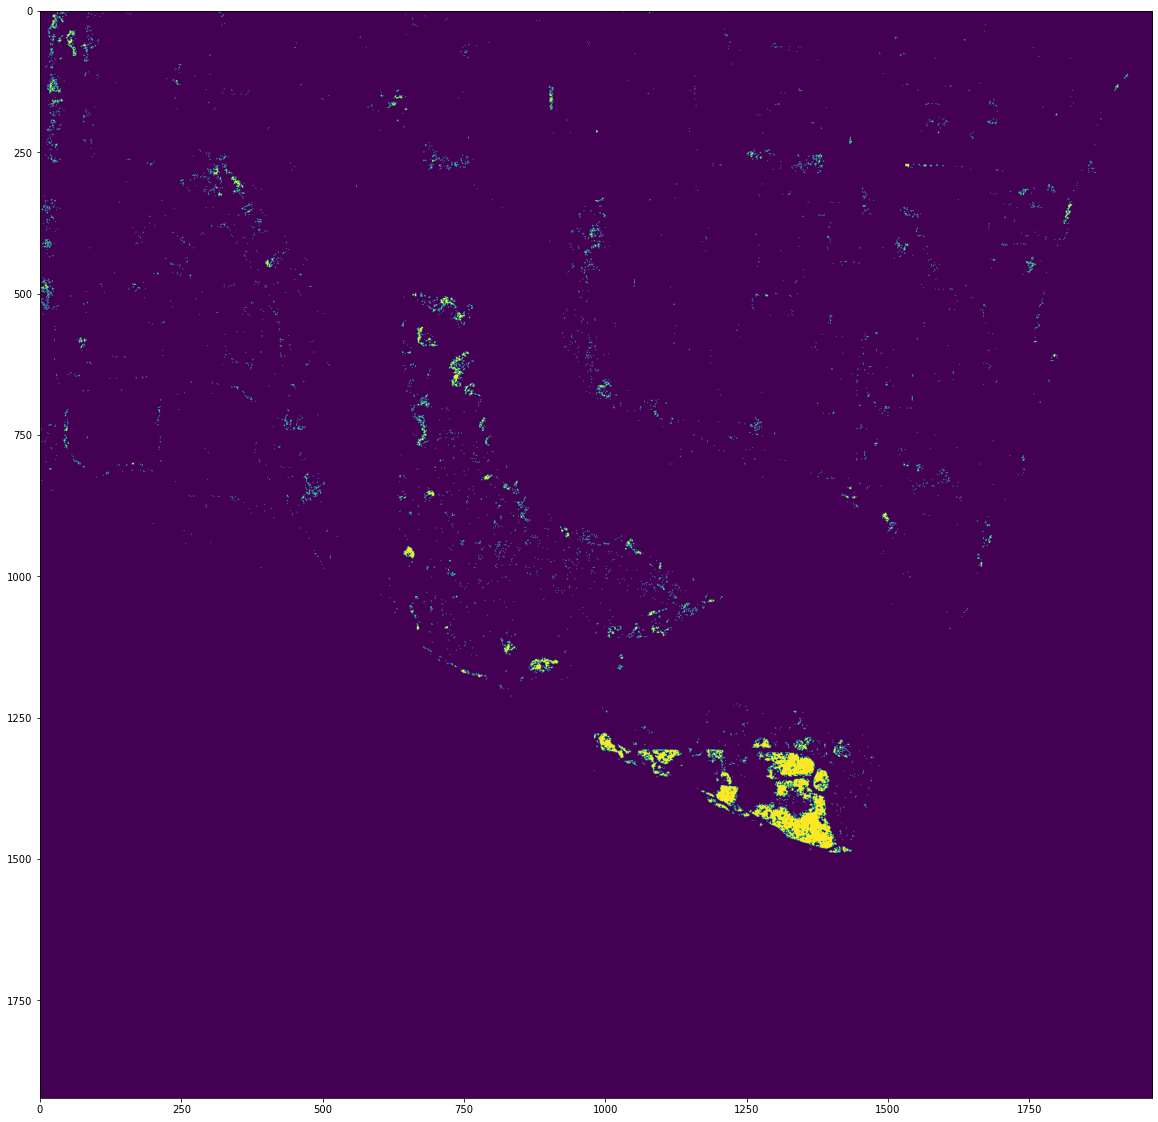

In [14]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(reconstructed)
plt.show()

In [ ]:
# #shoreline
# shoreline_itemid= 'ca_m_3411935_sw_11_060_20180724_20190209'

# shoreline_box = Polygon(
# [[-119.7141492874,34.3930950227],
#   [-119.7023203222,34.3930950227],
#   [-119.7023203222,34.3992922273],
#   [-119.7141492874,34.3992922273],
#   [-119.7141492874,34.3930950227]])

/tmp/ipykernel_357/3221137585.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


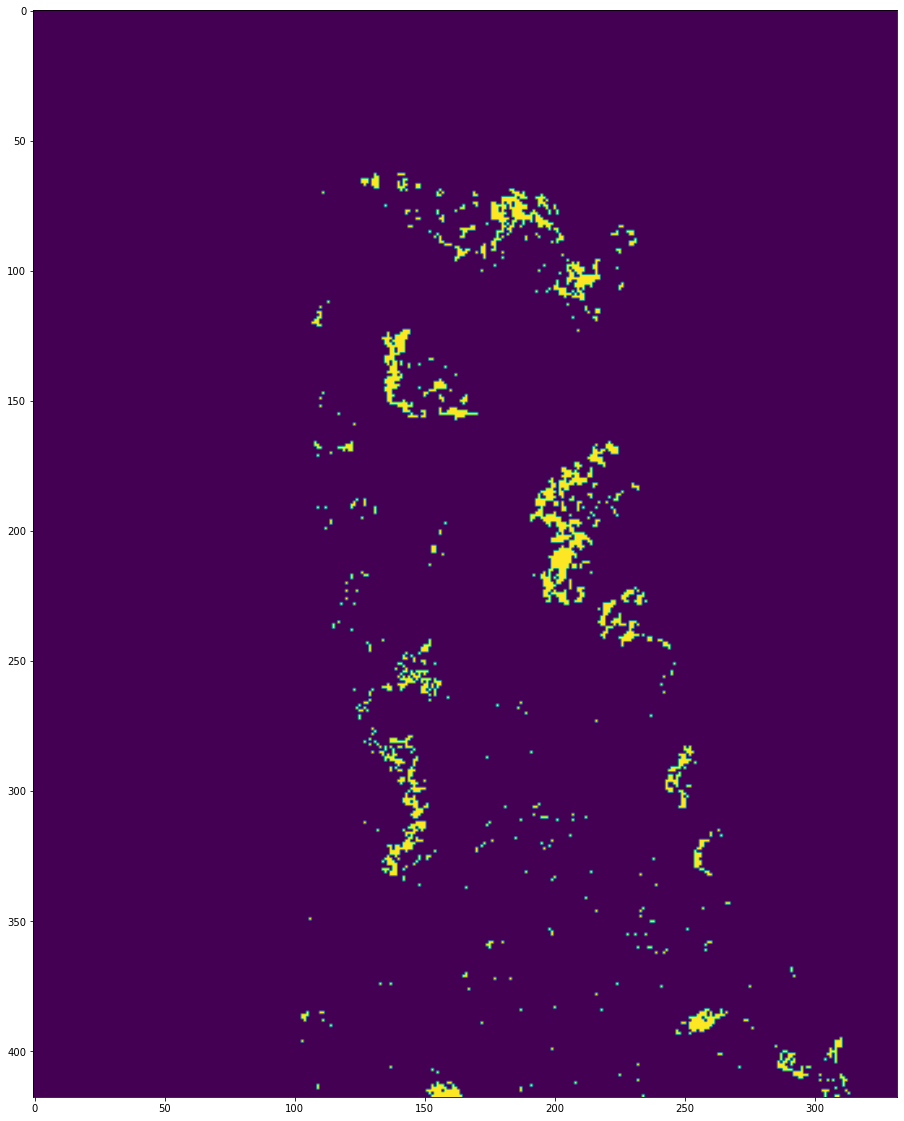

In [15]:
lagoon_zoom_box = Polygon([[-119.8501890501,34.4084820176],
                      [-119.8480929505,34.4084820176],
                      [-119.8480929505,34.4106942936],
                      [-119.8501890501,34.4106942936],
                      [-119.8501890501,34.4084820176]])

lagoon_zoom = mask_ndvi_and_predict(itemid, lagoon_zoom_box,rfc)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(lagoon_zoom)
plt.show()

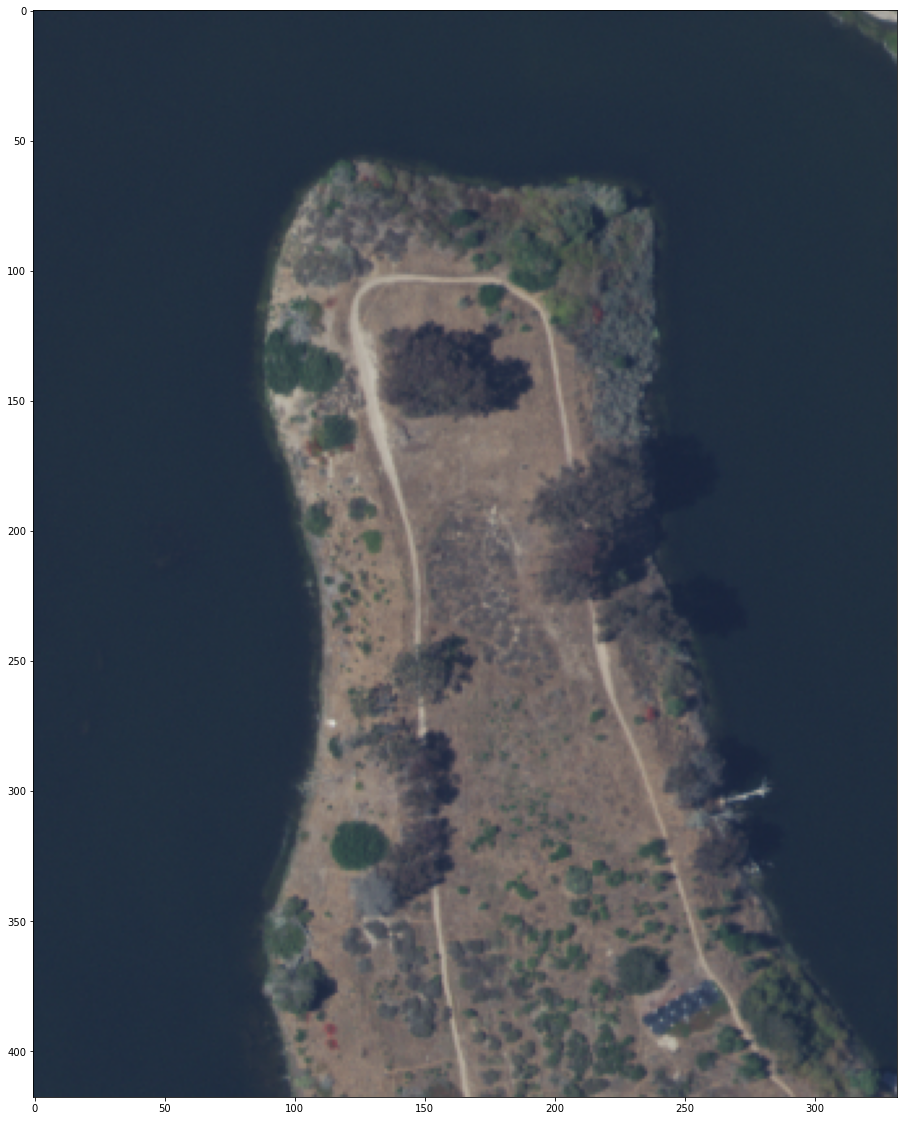

In [16]:
plot_window_in_scene(itemid, lagoon_zoom_box)

In [11]:
tree_box = Polygon([[-119.8494252218,34.4098185304],
                    [-119.8490819918,34.4098185304],
                    [-119.8490819918,34.4100837989],
                    [-119.8494252218,34.4100837989],
                    [-119.8494252218,34.4098185304]])

/tmp/ipykernel_2225/3221137585.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


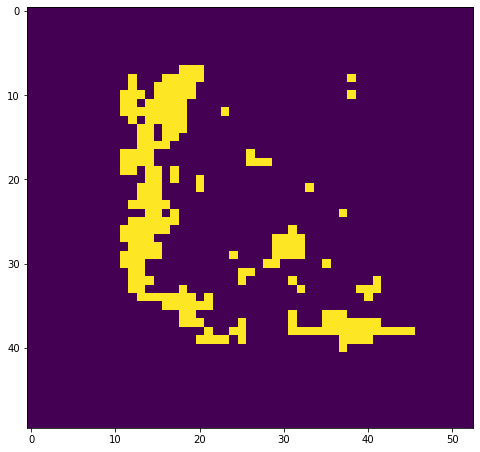

In [36]:
tree_predict = mask_ndvi_and_predict(itemid, tree_box, rfc)
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(tree_predict)
plt.show()

In [31]:
tree_ndvi = select_ndvi_image(itemid,tree_box)
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(tree_ndvi)
# plt.show()

/tmp/ipykernel_2225/3221137585.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


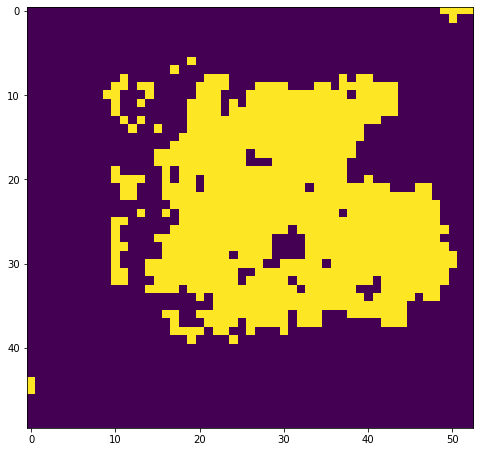

In [37]:
true_tree = tree_ndvi - tree_predict
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(true_tree)
plt.show()

In [23]:
tree_naip = open_window_in_scene(itemid, tree_box)

In [39]:
p = (tree_naip*tree_predict).reshape([4,-1]).T
p = pd.DataFrame(p, columns =['r','g','b','nir'])
df = p[(p.r!=0) & (p.g!=0) & (p.b!=0) & (p.nir!=0)]
df['classified']=1
df

/tmp/ipykernel_2225/241382099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['classified']=1


,r,g,b,nir,classified
389,86.0,83.0,92.0,152.0,1
390,81.0,75.0,87.0,145.0,1
391,85.0,78.0,86.0,140.0,1
436,85.0,85.0,93.0,142.0,1
440,83.0,76.0,88.0,125.0,1
...,...,...,...,...,...
2104,88.0,88.0,91.0,150.0,1
2105,84.0,83.0,89.0,146.0,1
2106,93.0,90.0,92.0,148.0,1
2107,97.0,89.0,91.0,147.0,1


In [40]:
icep_predict = tree_naip*true_tree
p = icep_predict.reshape([4,-1]).T
p = pd.DataFrame(p, columns =['r','g','b','nir'])
df2 = p[(p.r!=0) & (p.g!=0) & (p.b!=0) & (p.nir!=0)]
df2['classified']=0
df2

/tmp/ipykernel_2225/1296004054.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['classified']=0


,r,g,b,nir,classified
49,89.0,105.0,88.0,161.0,0
50,82.0,98.0,83.0,157.0,0
51,85.0,98.0,85.0,150.0,0
52,88.0,95.0,90.0,135.0,0
103,87.0,96.0,83.0,148.0,0
...,...,...,...,...,...
2044,77.0,79.0,87.0,127.0,0
2086,95.0,95.0,92.0,162.0,0
2091,82.0,86.0,90.0,142.0,0
2332,98.0,99.0,96.0,149.0,0


In [43]:
df = pd.concat([df,df2])
df

,r,g,b,nir,classified
389,86.0,83.0,92.0,152.0,1
390,81.0,75.0,87.0,145.0,1
391,85.0,78.0,86.0,140.0,1
436,85.0,85.0,93.0,142.0,1
440,83.0,76.0,88.0,125.0,1
...,...,...,...,...,...
2044,77.0,79.0,87.0,127.0,0
2086,95.0,95.0,92.0,162.0,0
2091,82.0,86.0,90.0,142.0,0
2332,98.0,99.0,96.0,149.0,0


In [45]:
df.to_csv(os.path.join(os.getcwd(),'training_set','aux_data','tree_naip_values.csv'))

In [44]:
os.getcwd()

'/home/jovyan/msai4earth-esa/iceplant_detection'

In [ ]:

# # ********* DANGERMOND RESERVE 2018 NAIP SCENE ******
# itemid = 'ca_m_3412037_nw_10_060_20180913_20190208'

# reduce_box = Polygon([
#     [-120.4731712312,34.4464554252],
#     [-120.4602250497,34.4464554252],
#     [-120.4602250497,34.4566394481],
#     [-120.4731712312,34.4566394481],
#     [-120.4731712312,34.4464554252]])

In [ ]:
# dangermond_iceplant = predict_over_subset(itemid, reduce_box,rfc)

In [ ]:
# fig, ax = plt.subplots(figsize=(20, 20))
# ax.imshow(dangermond_iceplant)
# plt.show()

In [ ]:
# reduce_box2 = Polygon([
#     [-120.4694755983,34.4526766824],
#     [-120.4593511485,34.4526766824],
#     [-120.4593511485,34.4611333067],
#     [-120.4694755983,34.4611333067],
#     [-120.4694755983,34.4526766824]])

# dangermond_iceplant2 = predict_over_subset(itemid, reduce_box2,rfc)

In [ ]:
# fig, ax = plt.subplots(figsize=(20, 20))
# ax.imshow(dangermond_iceplant2)
# plt.show()

In [ ]:
# # Visualization of RGB bands to double check this is our AOI
# #plt.imshow(np.moveaxis(rasterio.open(href).read([1,2,3], window=win),0,-1))

# URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
# catalog = pystac_client.Client.open(URL)

# # ********* HERE I KNOW WHICH IMAGE TEHSE POINTS ARE IN ******
# itemid = itemid,
# search = catalog.search(collections=["naip"], ids = itemid)
# item = list(search.get_items())[0]
# # sign and open item
# href = pc.sign(item.assets["image"].href)

# fig, ax = plt.subplots(figsize=(20, 20))
# ax.imshow(np.moveaxis(rasterio.open(href).read([1,2,3], window=win),0,-1))
# plt.show()